In [36]:
import os
EXPERIMENT_DIR =  os.path.abspath(os.getcwd()) + '/../../logs/identification_logs/'
EXPERIMENT_DIR

'/home/ivan/Projects/SL/alpha_py/scripts/calibration/../../logs/identification_logs/'

## Data proc

In [37]:
%matplotlib widget


import os
from enum import Enum

import json

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


class PlotSize(Enum):
    HALF_SCREEN = 8
    FULL_SCREEN = 16


class VehicleLogViz():

    def __init__(self, log_filepath):
        
        # load log data
        self._log_filepath = log_filepath 
        self._log_filename = os.path.basename(self._log_filepath)

        self._log_data = self.load_vehicle_log_from_file()

        # setup plot
        self.fig, self.ax = plt.subplots(1, 1, figsize=[PlotSize.HALF_SCREEN.value, 8.0])
        plt.subplots_adjust(bottom=0.05, right=0.98, top=0.96, left=0.04)

        self.ax.axhline(y=0, color='k')
        self.ax.axvline(x=0, color='k')
        self.ax.grid(True, which='both')

        self.ax.set_xlabel('time, [s]')
        self.ax.set_ylabel('data')

        plt.title(self._log_filename)

        # declaration of plots
        self.sw_angle_plot,      = self.ax.plot([], [], color="#483D8B", lw=2, ls=':', label='sw_angle [deg]')
        self.sw_torque_plot,     = self.ax.plot([], [], color="#8000FF", lw=2, ls='-', label='sw_torque [m/s]')
        self.vehicle_speed_plot, = self.ax.plot([], [], color="#FFFF00", lw=2, ls='-', label='vehicle_speed [cm/s]')
        self.approximation_plot, = self.ax.plot([], [], color="#FFA500", lw=1, ls='-', label='sw_angle_approximation [deg]')


    def load_vehicle_log_from_file(self):

        try:
            log_file_handler = open(self._log_filepath, 'r')

        except Exception as err:
            print("Can't open file " + self._log_filepath + ". " + str(err))

        try:
            vehicle_log_data = json.load(log_file_handler)

        except Exception as err:
            print("Can't load log from file " + self._log_filepath + ". " + str(err))

        log_file_handler.close()

        return vehicle_log_data
    

    def plot_vehicle_log(self, tmin = float('-inf'), tmax = float('inf')):

        # declaration of plot data
        t = []
        sw_angle = []
        torque_cmd = []
        vehicle_speed = []

        # fill plot data
        for element in self._log_data["data"]:
            
            # clamp data
            time = float(element['t'])
            if time < tmin or time > tmax:
                continue

            t.append(time)
            sw_angle.append(float(element['sw_angle']))
            torque_cmd.append(float(element['torque_cmd']) * 10)
            vehicle_speed.append(float(element['vehicle_speed']) * 100)

        # set torque for brief
        self._torque = torque_cmd[len(torque_cmd) // 2]

        # approximation
        t_data, approx_data = self._line_approximation(t, sw_angle)
        self.approximation_plot.set_data(t_data, approx_data)

        # set other data
        self.sw_angle_plot.set_data(t, sw_angle)
        self.sw_torque_plot.set_data(t, torque_cmd)

        # show plot
        self.ax.relim()     
        self.ax.autoscale()

        plt.show()


    def _line_approximation(self, t, source_data):

        # find start of approximation - skip zero values
        start_idx = 0
        for idx, el in enumerate(source_data):

            if abs(el - source_data[0] ) > 1:
                start_idx = idx 
                break

        # approximation
        popt, _ = curve_fit(self._line_func, t[start_idx:], source_data[start_idx:])
        tang, y_0 = popt

        # brief
        self._tang = tang
        print('y1 = %.5f * x + %.5f' % (tang, y_0))
        print( self.get_step_response_info()  )

        # approximation data
        approx_data = []
        for idx in range(start_idx, len(t)):
            approx_data.append( self._line_func(t[idx], tang, y_0) )
        
        return t[start_idx:], approx_data

 
    # define the true objective function for approximation
    def _line_func(self, x, a, b):
        return a * x + b


    def save(self, fname = None):
        if not fname : fname = str(self._filename[:-4])
        plt.savefig('.' + str(fname) + '.png')


    def get_step_response_info(self):
        return self._torque, self._tang


In [38]:
RES = dict()

/home/ivan/Projects/SL/alpha_py/scripts/calibration/../../logs/identification_logs/-350.log
y1 = -232.58087 * x + 39.56696
(-350.0, -232.58087234536768)


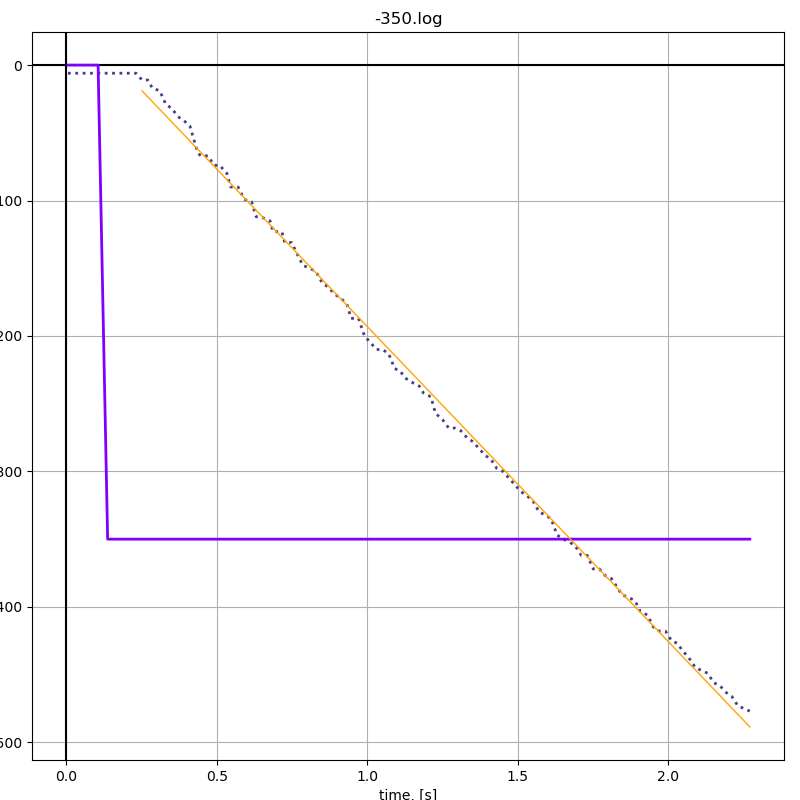

/home/ivan/Projects/SL/alpha_py/scripts/calibration/../../logs/identification_logs/-200.log
y1 = 0.00000 * x + 12.00000
(-200.0, 1.429472475614417e-10)


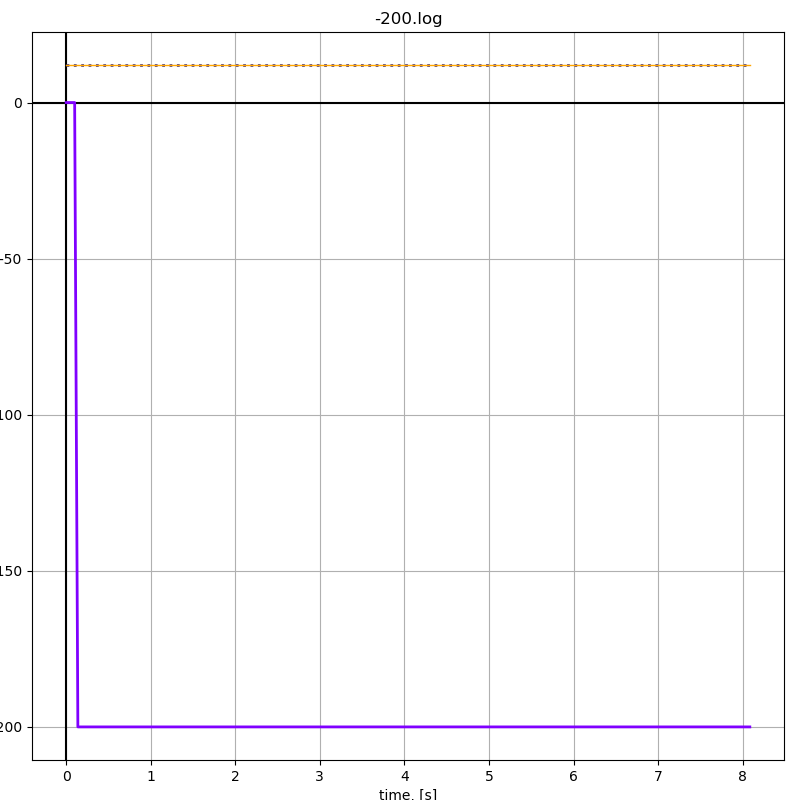

/home/ivan/Projects/SL/alpha_py/scripts/calibration/../../logs/identification_logs/-150.log
y1 = -0.00000 * x + 12.00000
(-150.0, -1.009678688924229e-08)


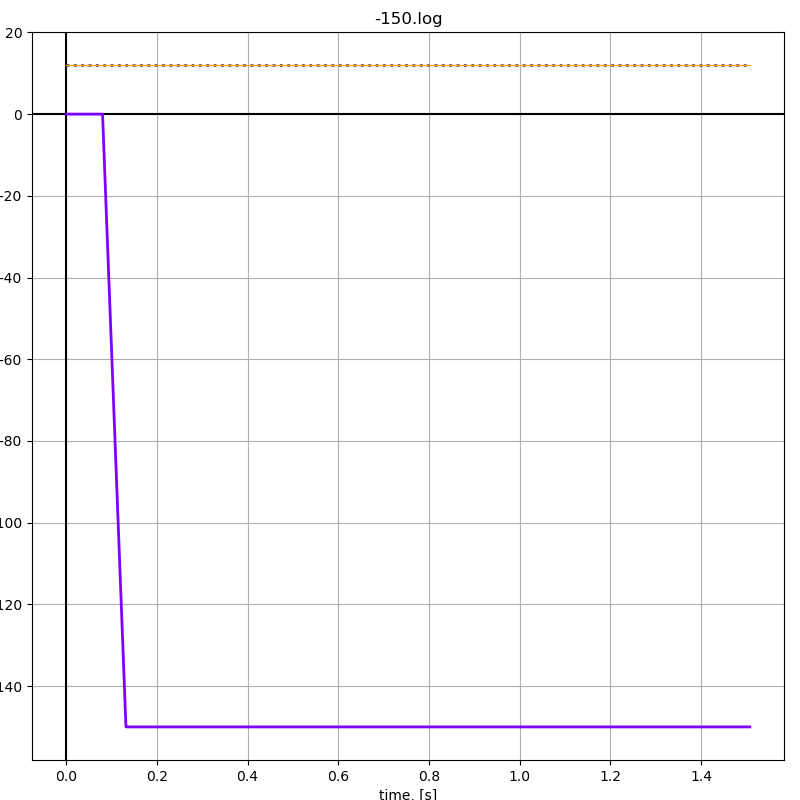

/home/ivan/Projects/SL/alpha_py/scripts/calibration/../../logs/identification_logs/-400.log
y1 = -256.38737 * x + 49.77952
(-400.0, -256.38736945812417)


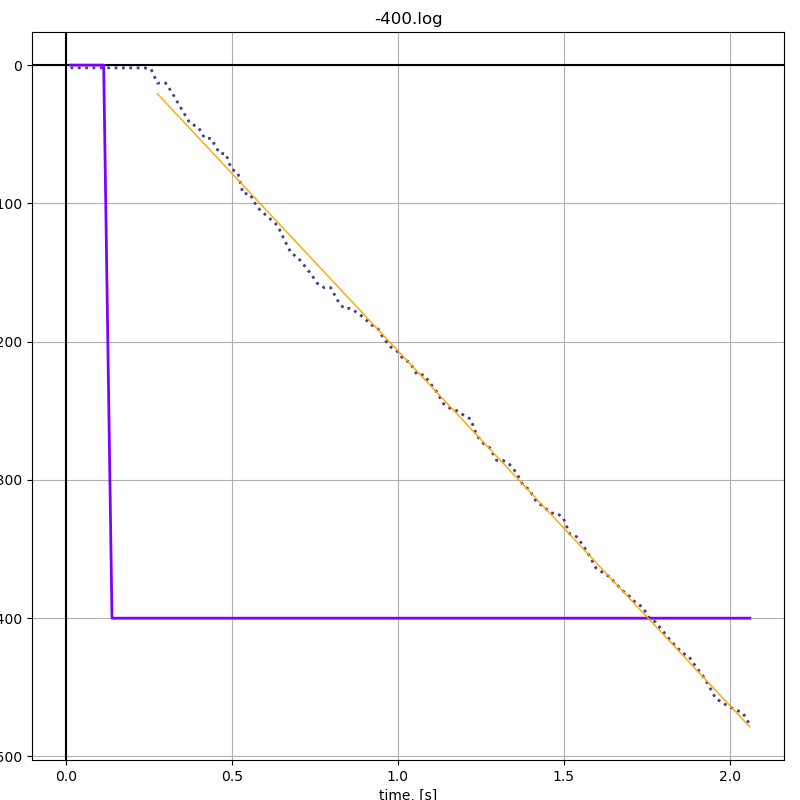

/home/ivan/Projects/SL/alpha_py/scripts/calibration/../../logs/identification_logs/-300.log
y1 = -196.78046 * x + 42.44307
(-300.0, -196.78046143972028)


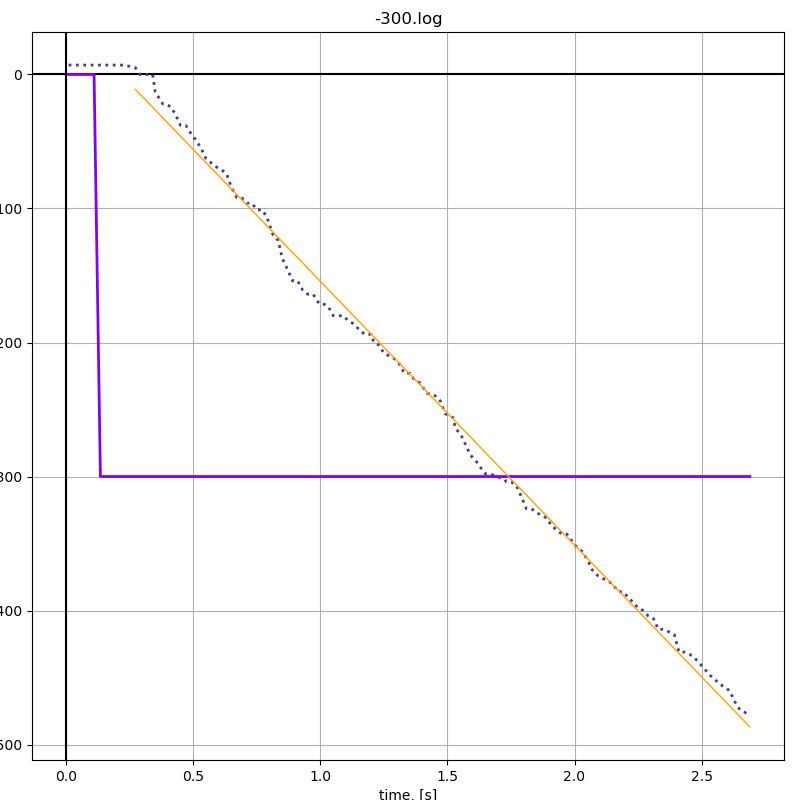

/home/ivan/Projects/SL/alpha_py/scripts/calibration/../../logs/identification_logs/-250.log
y1 = -160.28569 * x + 3.43745
(-250.0, -160.28569008395993)


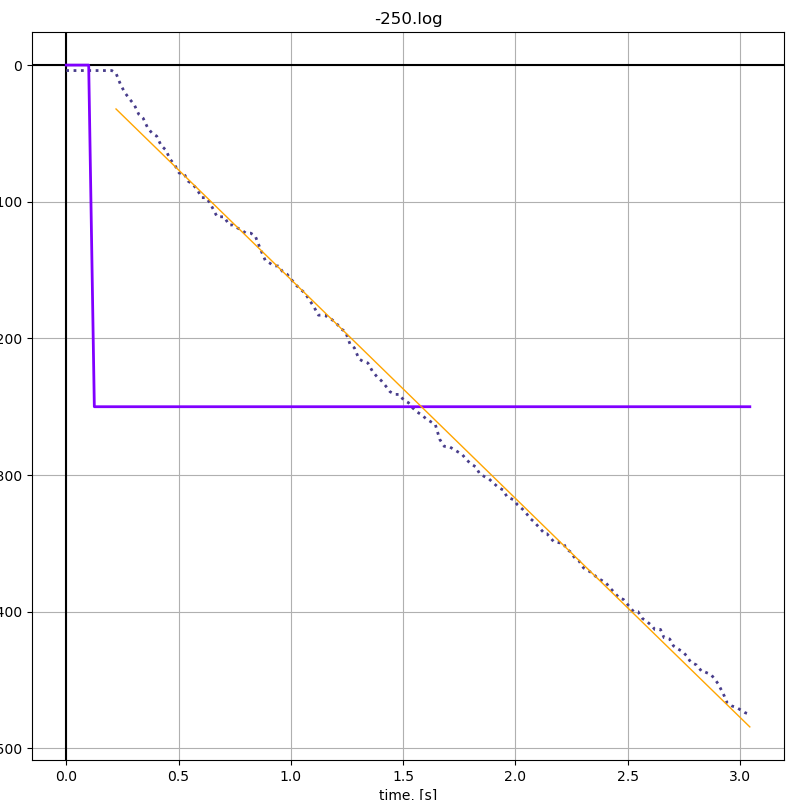

In [39]:
import os

files = [EXPERIMENT_DIR + el for el in os.listdir(EXPERIMENT_DIR)]

for path in files:
    print(path)
    
    viz = VehicleLogViz(path)
    viz.plot_vehicle_log()

    torq, tan = viz.get_step_response_info()

    if abs(tan) < 0.01:
        tan = 0

    RES.update({torq: tan})
        

# Result

In [40]:
# save to file
with open('lut.txt', 'w+') as file:
    for torque, rot in RES.items():
        file.write(f'{rot} {torque}\n')

/tmp/ipykernel_7974/1186783497.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-ro" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(torque, tang, '-ro', color="#483D8B", lw=2, ls=':', label='tang(torque)')
/tmp/ipykernel_7974/1186783497.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(torque, tang, '-ro', color="#483D8B", lw=2, ls=':', label='tang(torque)')


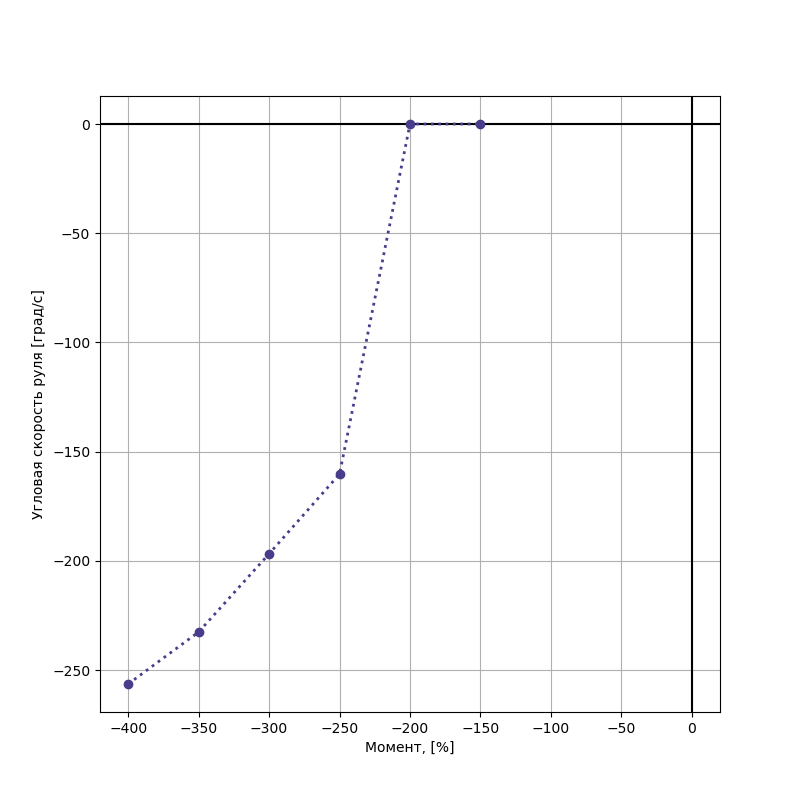

In [41]:
fig, ax = plt.subplots(1, 1, figsize=[PlotSize.HALF_SCREEN.value, 8.0], facecolor='#FFFFFF')


ax.set_xlabel('Момент, [%]')
ax.set_ylabel('Угловая скорость руля [град/c]')

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True, which='both')

# LUT result
torque, tang = zip(*(sorted(RES.items())))
ax.plot(torque, tang, '-ro', color="#483D8B", lw=2, ls=':', label='tang(torque)')



plt.show()